<a href="https://colab.research.google.com/github/llcorrea/agriculture_time_prediction/blob/main/Agriculture_time_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Task description**

**Objetivo:**

Estimar o tempo em que um pulverizador finaliza uma ordem de serviço ($T_t$). 

O tempo ($T_t$) se divide em:
* Efetivo (E): tempo em que o equipamento encontra-se trabalhando dentro do talhão.
* Manobra (M): Tempo em que o equipamento encontra-se indo de uma linha para a próxima.
* Deslocamento (D): Tempo em que o equipamento encontra-se deslocando dentro do talhão. (Sem estar em efetivo nem em manobra).
* Parada (F): Tempo em que o equipamento encontra-se parado. Isto pode ser por dissimiles motivos: aguardando produto, abastecimento, manutenção.

> Neste problema desconsideraremos o tempo de parada, logo:
>
> $T_t = E + D+ M$

Todos os tempos encontram-se em segundos.

Outros dados de interesse:
* **boom_len:** Largura do implemento do pulverizador (pé).  
* **ACRES:** Área trabalhada dos talhões da ordem de serviço (acres).
* **Velocidade média de efetivo:** 24 km/h.
* Os outros campos do dataset são índices que caracterizam os talhões.

**O dataset fora fornecido para o teste.**

#**Importing libs**

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

#**Useful functions**

In [ ]:
def dataset_description(df_obj):
  ##describe the dataset
  print('Dataset shape: %s\n' % (df_obj.shape, ))
  print('Dataset columns: %s\n' % df_obj.columns)

  display(df_obj)
  #display(df_obj.head())
  #display(df_obj.tail())
  
  print('\nColumns description:\n')
  display(df_obj.info())
  display(df_obj.describe())
  
  print('\nNull values:\n')
  display(df_obj.isnull().sum())

In [ ]:
def get_correlations(obj_corr, corr_threshold=0.5):
  ##create a dict with the highest correlations and remove the duplicated combinations between all dataset features
  series = obj_corr.unstack()
  dict_corr={} #key=tuple of feature, value=corr
  for index, value in series.items():
      if (index[0]!=index[1]) and (abs(value) > corr_threshold) and ((index[0], index[1]) not in dict_corr) and ((index[1], index[0]) not in dict_corr):
        dict_corr[(index[0], index[1])]=value
  
  return dict_corr

In [ ]:
def calc_regression_metrics(model_name, real_y, prediction):
  ##regression loss metrics
  display(model_name+' prediction | Regression metric:')
  calc_r2=r2_score(real_y, prediction)
  calc_mae=mean_absolute_error(real_y, prediction)
  calc_mse=mean_squared_error(real_y, prediction)
  print('r2:', calc_r2)
  print('MAE:', calc_mae)
  print('MSE:', calc_mse)
  return calc_r2, calc_mae, calc_mse

In [ ]:
def std_features(train_X, val_X, vars):
  ##standardize features
  std_sca=StandardScaler()
  std_sca.fit(train_X[vars])
  train_X.loc[:, vars]=std_sca.transform(train_X[vars])
  val_X.loc[:, vars]=std_sca.transform(val_X[vars])
  return train_X, val_X

def norm_features(train_X, val_X, vars):
  ##min-max normalization
  mm_sca=MinMaxScaler()
  mm_sca.fit(train_X[vars])
  train_X.loc[:, vars]=mm_sca.transform(train_X[vars])
  val_X.loc[:, vars]=mm_sca.transform(val_X[vars])
  return train_X, val_X

#**Loading dataset**

In [ ]:
try:
  train_data = pd.read_csv('problems_dataset.csv')  
except:
  uploaded = files.upload()
  train_data = pd.read_csv('problems_dataset.csv')


# **EDA step**

> **Total de dados:** 113 registros\
> **Total de colunas:** 23 colunas, considerando uma coluna de índices\
> **Total de atributos:** 22 features, considerando uma coluna de chaves\
> **Variável resposta (*target*):** A variável resposta (*tempo_servico*), definida abaixo, representa o tempo em que um pulverizador finaliza uma ordem de serviço ($T_t$), onde $T_t$ é composto pela soma de outras três variáveis do dataset: $T_t = E + D+ M$. 

* Cada registro representa uma ordem de serviço previamente realizada.

* Assim, nesse teste, a variável resposta (*tempo_servico*) é utilizada na formulação do problema de ML supervisionado, o qual visa estimar o tempo em que um dado pulverizador finalizará uma ordem de serviço, considerando ordens de serviço anteriores por meio das variáveis independentes do dataset.

* **Os atributos *E, D, M e F* são excluídos do conjunto de features de treinamento, pois compõe a variável alvo a ser estimada.**

* **Todos os atributos, com exceção da *KEY*, são atributos numéricos.**

> **Dados ausentes ou nulos:**

* **Não há dados ausentes ou nulos em nenhuma das colunas do dataset.**

> **Atributo sem variação: (remover)**
* *RATE_GAL_ACRES* (valores zerados)

> **Atributos a serem normalizados:**
* *ACRES, RATE_LBS_ACRES, ITER, OBJECTID, num_polygons, boom_len, AREA_TOTAL*

In [ ]:
dataset_description(train_data)

Dataset shape: (113, 23)

Dataset columns: Index(['Unnamed: 0', 'KEY', 'ACRES', 'RATE_GAL_ACRES', 'RATE_LBS_ACRES', 'D',
       'E', 'F', 'M', 'ITER', 'OBJECTID', 'convexity', 'principal_axis_ratio',
       'rectangularity', 'eliptic_variance', 'circular_variance',
       'compactness', 'perimeter', 'num_polygons', 'weighted_convexity',
       'boom_len', 'AREA_TOTAL', 'AREA_RATIO'],
      dtype='object')



,Unnamed: 0,KEY,ACRES,RATE_GAL_ACRES,RATE_LBS_ACRES,D,E,F,M,ITER,OBJECTID,convexity,principal_axis_ratio,rectangularity,eliptic_variance,circular_variance,compactness,perimeter,num_polygons,weighted_convexity,boom_len,AREA_TOTAL,AREA_RATIO
0,0,2020-10-08|8117|3604 - C51 - TG 7300,8.60,0.0,2000.04,4.0,231.0,117.0,1.0,0,8117.0,0.997092,0.143203,0.923280,0.010304,0.293760,0.763728,0.008844,1,0.997092,80,8.971335,0.958609
1,1,2020-10-09|4286|3203 - L90 - TG 7300,56.93,0.0,316.95,1796.0,713.0,2573.0,19.0,0,4286.0,0.497117,0.610057,0.718599,0.134875,0.080754,0.426239,0.040843,3,0.859118,85,59.594696,0.955286
2,2,2020-10-12|5477|3203 - L90 - TG 7300,40.77,0.0,319.87,134.0,1309.0,0.0,470.0,0,5477.0,0.743512,0.647334,0.884944,0.120287,0.068687,0.641314,0.022984,1,0.743512,85,42.723583,0.954274
3,3,2020-10-13|3101|3203 - L90 - TG 7300,38.80,0.0,406.67,678.0,1563.0,0.0,255.0,0,3101.0,0.999988,0.563219,0.947371,0.013893,0.024228,0.902149,0.015932,1,0.999988,85,40.622692,0.955131
4,4,2020-10-08|575|3003 - 6S - TG 7300,6.13,0.0,248.11,20.0,342.0,159.0,0.0,0,575.0,0.995826,0.025848,0.827361,0.041749,0.932529,0.614919,0.009249,1,0.995826,80,6.360773,0.963719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,108,2020-10-08|470|3003 - 6S - TG 7300,28.84,0.0,258.01,65.0,1557.0,2323.0,0.0,1,470.0,0.817520,0.746394,0.850457,0.041219,0.040941,0.715819,0.017237,2,0.995556,80,29.938136,0.963320
109,109,2020-10-08|1214|3003 - 6S - TG 7300,68.47,0.0,258.01,28.0,2878.0,355.0,0.0,1,1214.0,0.653959,0.435554,0.781076,0.089068,0.079620,0.525579,0.036183,3,0.998321,80,71.114013,0.962820
110,110,2020-10-19|7670|3001 - C36 - TG 6200,77.55,0.0,100.00,0.0,5.0,0.0,2.0,11,7670.0,0.984324,0.298417,0.979155,0.064777,0.069622,0.860303,0.023600,1,0.984324,70,81.061180,0.956685
111,111,2020-11-04|2701|3604 - C51 - TG 7300,13.81,0.0,450.01,2.0,474.0,0.0,0.0,19,2701.0,0.986982,0.086709,0.744301,0.031987,0.369848,0.676720,0.012661,1,0.986982,80,14.434266,0.956751



Columns description:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            113 non-null    int64  
 1   KEY                   113 non-null    object 
 2   ACRES                 113 non-null    float64
 3   RATE_GAL_ACRES        113 non-null    float64
 4   RATE_LBS_ACRES        113 non-null    float64
 5   D                     113 non-null    float64
 6   E                     113 non-null    float64
 7   F                     113 non-null    float64
 8   M                     113 non-null    float64
 9   ITER                  113 non-null    int64  
 10  OBJECTID              113 non-null    float64
 11  convexity             113 non-null    float64
 12  principal_axis_ratio  113 non-null    float64
 13  rectangularity        113 non-null    float64
 14  eliptic_variance      113 non-null    float64
 15  

None

,Unnamed: 0,ACRES,RATE_GAL_ACRES,RATE_LBS_ACRES,D,E,F,M,ITER,OBJECTID,convexity,principal_axis_ratio,rectangularity,eliptic_variance,circular_variance,compactness,perimeter,num_polygons,weighted_convexity,boom_len,AREA_TOTAL,AREA_RATIO
count,113.00000,113.000000,113.0,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,56.00000,56.360531,0.0,309.578142,174.530973,1860.283186,643.849558,92.628319,0.460177,3264.327434,0.845480,0.341616,0.768270,0.090263,0.211801,0.672206,0.027700,1.495575,0.893593,77.035398,60.618727,0.941329
std,32.76431,46.793619,0.0,210.074786,315.341370,1688.328328,1260.695027,240.563037,2.709228,2599.273516,0.178180,0.210566,0.159451,0.079703,0.313864,0.164445,0.022114,1.570509,0.132060,7.215966,49.193770,0.106287
min,0.00000,1.040000,0.0,1.000000,0.000000,5.000000,0.000000,0.000000,0.000000,65.000000,0.330061,0.025178,0.296838,0.008956,0.023967,0.241356,0.002924,1.000000,0.424034,60.000000,1.088398,0.295560
25%,28.00000,20.140000,0.0,225.000000,24.000000,685.000000,0.000000,0.000000,0.000000,1044.000000,0.742120,0.169594,0.684061,0.028517,0.072492,0.541255,0.014835,1.000000,0.824010,70.000000,21.030166,0.956764
50%,56.00000,47.370000,0.0,296.590000,48.000000,1557.000000,147.000000,0.000000,0.000000,2597.000000,0.928484,0.298417,0.800049,0.064777,0.115536,0.686326,0.023957,1.000000,0.951865,80.000000,51.457798,0.958836
75%,84.00000,77.120000,0.0,400.010000,180.000000,2335.000000,587.000000,19.000000,0.000000,4732.000000,0.995910,0.506028,0.884944,0.126408,0.194424,0.815395,0.030293,1.000000,0.996384,80.000000,82.041280,0.962556
max,112.00000,270.700000,0.0,2000.040000,1796.000000,9449.000000,7676.000000,1488.000000,19.000000,8117.000000,1.000000,0.790778,0.998288,0.411700,2.358658,0.908125,0.157214,12.000000,1.000000,85.000000,283.119214,1.147650



Null values:



Unnamed: 0              0
KEY                     0
ACRES                   0
RATE_GAL_ACRES          0
RATE_LBS_ACRES          0
D                       0
E                       0
F                       0
M                       0
ITER                    0
OBJECTID                0
convexity               0
principal_axis_ratio    0
rectangularity          0
eliptic_variance        0
circular_variance       0
compactness             0
perimeter               0
num_polygons            0
weighted_convexity      0
boom_len                0
AREA_TOTAL              0
AREA_RATIO              0
dtype: int64

**Criação da variável resposta (*tempo_servico*):**

* Criação do target $y$ (*tempo_servico*) através da soma das variáveis *E, D e M*.

In [ ]:
##target feature tempo_servico
train_data['tempo_servico']=train_data['E']+train_data['D']+train_data['M']

display(train_data.describe())

,Unnamed: 0,ACRES,RATE_GAL_ACRES,RATE_LBS_ACRES,D,E,F,M,ITER,OBJECTID,convexity,principal_axis_ratio,rectangularity,eliptic_variance,circular_variance,compactness,perimeter,num_polygons,weighted_convexity,boom_len,AREA_TOTAL,AREA_RATIO,tempo_servico
count,113.00000,113.000000,113.0,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,56.00000,56.360531,0.0,309.578142,174.530973,1860.283186,643.849558,92.628319,0.460177,3264.327434,0.845480,0.341616,0.768270,0.090263,0.211801,0.672206,0.027700,1.495575,0.893593,77.035398,60.618727,0.941329,2127.442478
std,32.76431,46.793619,0.0,210.074786,315.341370,1688.328328,1260.695027,240.563037,2.709228,2599.273516,0.178180,0.210566,0.159451,0.079703,0.313864,0.164445,0.022114,1.570509,0.132060,7.215966,49.193770,0.106287,1804.608985
min,0.00000,1.040000,0.0,1.000000,0.000000,5.000000,0.000000,0.000000,0.000000,65.000000,0.330061,0.025178,0.296838,0.008956,0.023967,0.241356,0.002924,1.000000,0.424034,60.000000,1.088398,0.295560,7.000000
25%,28.00000,20.140000,0.0,225.000000,24.000000,685.000000,0.000000,0.000000,0.000000,1044.000000,0.742120,0.169594,0.684061,0.028517,0.072492,0.541255,0.014835,1.000000,0.824010,70.000000,21.030166,0.956764,777.000000
50%,56.00000,47.370000,0.0,296.590000,48.000000,1557.000000,147.000000,0.000000,0.000000,2597.000000,0.928484,0.298417,0.800049,0.064777,0.115536,0.686326,0.023957,1.000000,0.951865,80.000000,51.457798,0.958836,1830.000000
75%,84.00000,77.120000,0.0,400.010000,180.000000,2335.000000,587.000000,19.000000,0.000000,4732.000000,0.995910,0.506028,0.884944,0.126408,0.194424,0.815395,0.030293,1.000000,0.996384,80.000000,82.041280,0.962556,2769.000000
max,112.00000,270.700000,0.0,2000.040000,1796.000000,9449.000000,7676.000000,1488.000000,19.000000,8117.000000,1.000000,0.790778,0.998288,0.411700,2.358658,0.908125,0.157214,12.000000,1.000000,85.000000,283.119214,1.147650,10050.000000


**Análise das features mais relevantes:**

> **Target feature *tempo_servico*:**
>
> Variável resposta definida pela soma de outras três variáveis, onde $T = E + D+ M$ segundos.

* **Sem dados faltantes.**
* Valores desbalanceados, ordens de serviço variando entre 7.0 e 10050.0 segundos.
* 50% das ordens de serviço exigiram menos de 1830 segundos para serem finalizadas.
* 75% das ordens de serviço apresentam menos de 2769 segundos.

Total de valores da feature tempo_servico:
1830.0    2
3096.0    2
5287.0    1
2624.0    1
108.0     1
         ..
1366.0    1
9520.0    1
2390.0    1
673.0     1
236.0     1
Name: tempo_servico, Length: 111, dtype: int64

Classes de valores únicos da feature tempo_servico:
[2.360e+02 2.528e+03 1.913e+03 2.496e+03 3.620e+02 1.568e+03 5.100e+02
 1.802e+03 4.980e+02 2.001e+03 4.500e+03 3.910e+03 1.458e+03 3.543e+03
 8.049e+03 2.478e+03 4.600e+02 3.085e+03 2.268e+03 1.351e+03 9.800e+01
 8.670e+02 1.860e+02 1.189e+03 7.580e+02 6.220e+02 2.599e+03 1.875e+03
 4.849e+03 4.424e+03 7.670e+03 1.005e+04 2.769e+03 3.755e+03 8.520e+02
 1.570e+03 1.697e+03 2.693e+03 7.770e+02 1.159e+03 1.447e+03 6.750e+02
 4.554e+03 1.548e+03 4.026e+03 1.367e+03 2.314e+03 1.366e+03 1.702e+03
 2.094e+03 5.287e+03 9.520e+03 1.756e+03 6.280e+02 7.150e+02 6.730e+02
 4.920e+02 2.722e+03 3.768e+03 7.300e+02 2.383e+03 7.930e+02 1.384e+03
 4.548e+03 1.980e+03 3.096e+03 4.427e+03 1.864e+03 4.290e+02 3.586e+03
 5.580e+02 1.98

Text(0.5, 0, 'Tempo de Serviço')

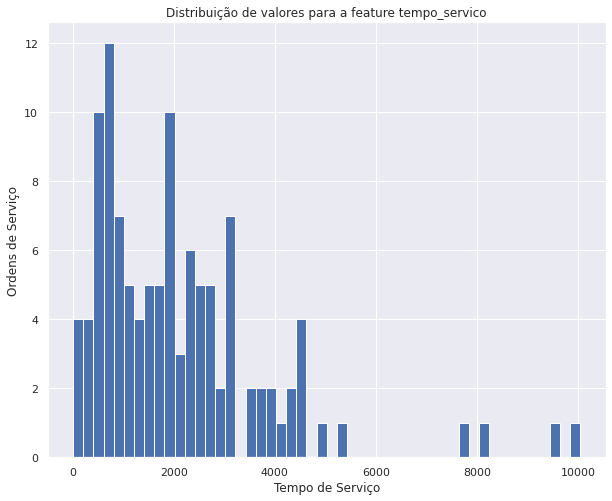

In [ ]:
var='tempo_servico'
print('Total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts()))
#print('Porcentagem total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts(normalize=True))) #feature com valores desbalanceados
print('Classes de valores únicos da feature %s:\n%s\n'  % (var, train_data[var].unique())) #descrição dos valores únicos da feature
print(train_data[var].describe(), '\n')
plt.figure(figsize=(10, 8))
ax=train_data[var].hist(bins=50)
ax.set_title('Distribuição de valores para a feature '+var)
ax.set_ylabel('Ordens de Serviço')
ax.set_xlabel('Tempo de Serviço')

> **Feature *ACRES*:**\
> Área trabalhada dos talhões da ordem de serviço (acres).

* **Sem dados faltantes.**
* Valores desbalanceados, ordens de serviço variando entre 1.04 e 270.7 acres.
* 50% das ordens de serviço apresentam menos de 47.37 acres.
* 75% das ordens de serviço apresentam menos de 77.12 acres.

Total de valores da feature ACRES:
8.48      1
25.16     1
103.46    1
48.54     1
101.81    1
         ..
89.01     1
78.53     1
74.45     1
77.55     1
149.50    1
Name: ACRES, Length: 113, dtype: int64

Classes de valores únicos da feature ACRES:
[  8.6   56.93  40.77  38.8    6.13  29.53   8.18  41.41  13.47  66.45
  77.12  89.01  53.67 133.66 191.14  79.15   9.98  74.51  48.54 103.6
   1.04  16.48   1.83  12.45  15.72  16.68  59.45  49.03 119.45 116.34
 149.5  270.7  101.81  82.89  14.8   45.05  30.64  53.66  13.91  39.93
  50.49  82.31 166.01  44.    44.97  33.31  79.47  58.42  47.37  43.66
  90.91 221.95  67.53  19.69  25.16  22.26  15.42  73.44  63.78  17.03
  78.85  16.63  26.    63.    56.02  41.09  34.2  145.11  43.29  27.09
  83.59  15.83  68.45  17.33  56.46  29.    77.59  81.1   37.74  23.92
   1.81   8.48  67.83 111.17  74.45  30.05  36.28 116.83   7.78  78.53
  82.16  16.78   7.66  20.14  11.52  18.68   8.65  72.3   46.23 103.46
 177.89  71.41  58.11  60.23  20.31  52.

Text(0.5, 0, 'ACRES')

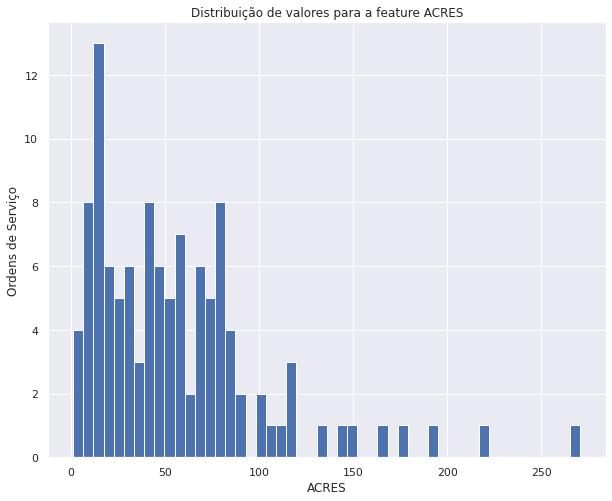

In [ ]:
var='ACRES'
print('Total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts()))
#print('Porcentagem total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts(normalize=True))) #feature com valores desbalanceados
print('Classes de valores únicos da feature %s:\n%s\n'  % (var, train_data[var].unique())) #descrição dos valores únicos da feature
print(train_data[var].describe(), '\n')
plt.figure(figsize=(10, 8))
ax=train_data[var].hist(bins=50)
ax.set_title('Distribuição de valores para a feature '+var)
ax.set_ylabel('Ordens de Serviço')
ax.set_xlabel('ACRES')

> **Feature *boom_len*:**\
> Largura do implemento do pulverizador (pé).

* **Sem dados faltantes.**
* Valores desbalanceados, largura do implemento do pulverizador usado nas ordens de serviço do dataset varia entre 60 e 85 pés.
* A feature assume apenas quatro valores distintos (feature categórica): 80, 85, 70, 60.
* 75% das ordens de serviço apresentam largura do implemento do pulverizador menor do que 80 pés.

Total de valores da feature boom_len:
80    65
70    20
85    17
60    11
Name: boom_len, dtype: int64

Classes de valores únicos da feature boom_len:
[80 85 70 60]

count    113.000000
mean      77.035398
std        7.215966
min       60.000000
25%       70.000000
50%       80.000000
75%       80.000000
max       85.000000
Name: boom_len, dtype: float64 



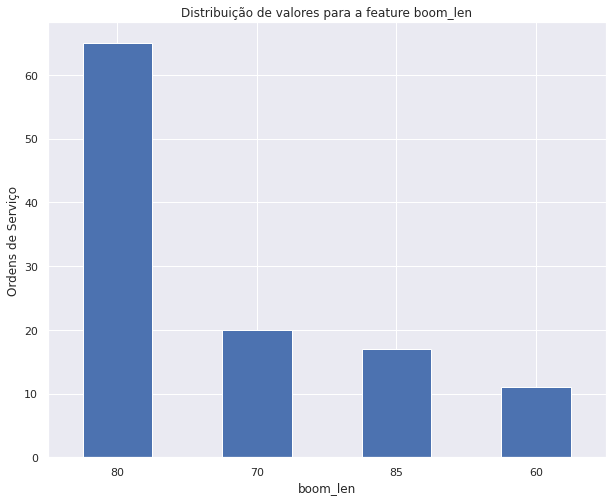

In [ ]:
var='boom_len'
print('Total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts()))
#print('Porcentagem total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts(normalize=True))) #feature com valores desbalanceados
print('Classes de valores únicos da feature %s:\n%s\n'  % (var, train_data[var].unique())) #descrição dos valores únicos da feature
print(train_data[var].describe(), '\n')
plt.figure(figsize=(10, 8))
ax=train_data[var].value_counts().plot.bar()
ax.set_title('Distribuição de valores para a feature '+var)
ax.set_ylabel('Ordens de Serviço')
ax.set_xlabel('boom_len')
ax.tick_params(axis='x', labelrotation=0)

> **Relação entre as principais features:**

* **Através dos gráficos, percebe-se que existe uma correlação positiva *ACRES* e variável resposta *tempo_servico*, considerando qualquer tamanho de implemento do pulverizador.**

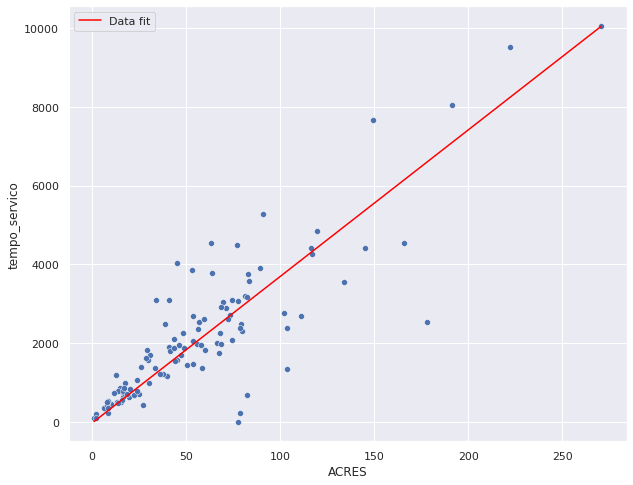

In [ ]:
sns.set()
plt.figure(figsize=(10, 8))
sns.scatterplot(x='ACRES', y='tempo_servico', data=train_data)
sns.lineplot(x=[min(train_data['ACRES']), max(train_data['ACRES'])], y = [min(train_data['tempo_servico']), max(train_data['tempo_servico'])], label='Data fit', color='red')

<Figure size 720x576 with 0 Axes>

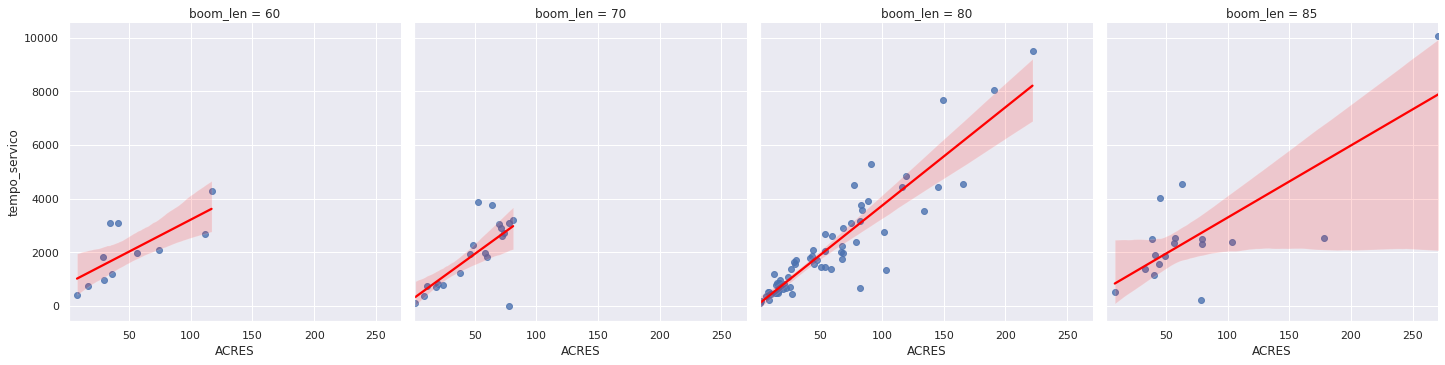

In [ ]:
sns.set()
plt.figure(figsize=(10, 8))
sns.lmplot(x='ACRES', y='tempo_servico', data=train_data, line_kws={'color':'red'}, col='boom_len')

> **Relação entre as features *ACRES* e *boom_len*:**

* **Através dos gráficos, percebe-se que a largura do implemento do pulverizador não é a única responsável por definir a área trabalhada dos talhões, visto que existem ordens de serviço com o maior valor possível de boom_len (85 pés) e com valor de *ACRES* mais baixo.**

* **Assim, faz-se necessária a investigação dos outros atributos do dataset que caracterizam a área trabalhada dos talhões.**

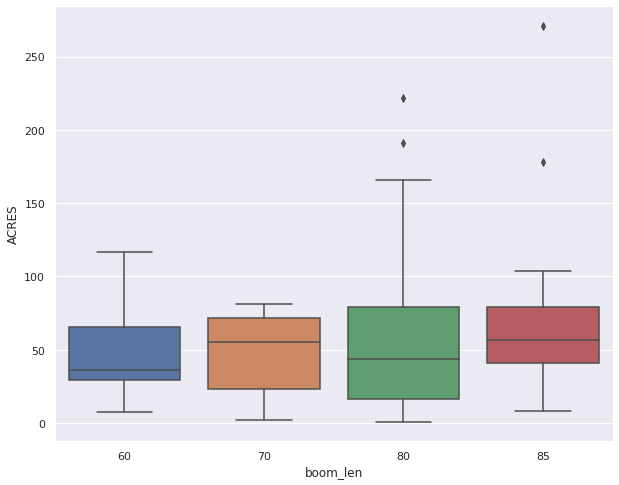

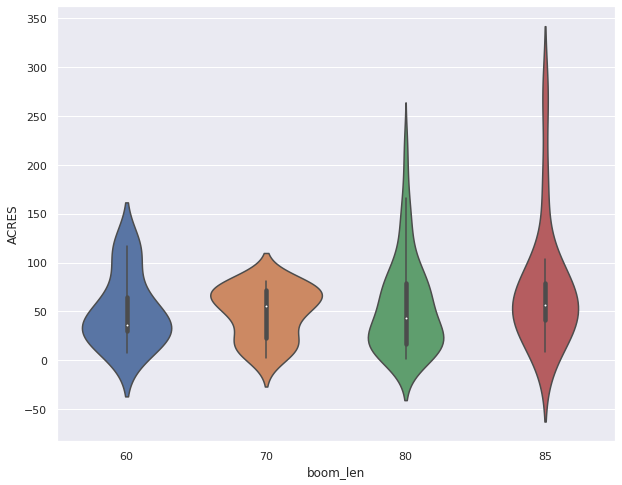

In [ ]:
sns.set()
plt.figure(figsize=(10, 8))
sns.boxplot(y='ACRES', x='boom_len', data=train_data)
plt.show()

sns.set()
plt.figure(figsize=(10, 8))
sns.violinplot(y='ACRES', x='boom_len', data=train_data)
plt.show()

# **Correlation between features**

> Determinação do grau de relacionamento entre duas features.

De forma mais evidente, nota-se alguns cenários de correlação entre as features e a variável resposta:
* Considerando cenários de correlação variando entre moderada à alta (0.5 < abs(corr) < 1.0):

1. Corelação positiva entre a variável resposta *tempo_servico* e as seguintes features:\
'ACRES': 0.8557544929764102\
'E': 0.9722693705368084\
'perimeter': 0.8300928076415588\
'AREA_TOTAL': 0.8533534818785105

2. Corelação negativa entre a variável resposta *tempo_servico* e as seguintes features:\
'convexity': -0.5472239896093055

Variáveis correlacionadas ao target podem indicar uma relevância maior para a estimativa do de novos valores.

{'ACRES': [0.8557544929764102], 'E': [0.9722693705368084], 'convexity': [-0.5472239896093055], 'perimeter': [0.8300928076415588], 'AREA_TOTAL': [0.8533534818785105]}


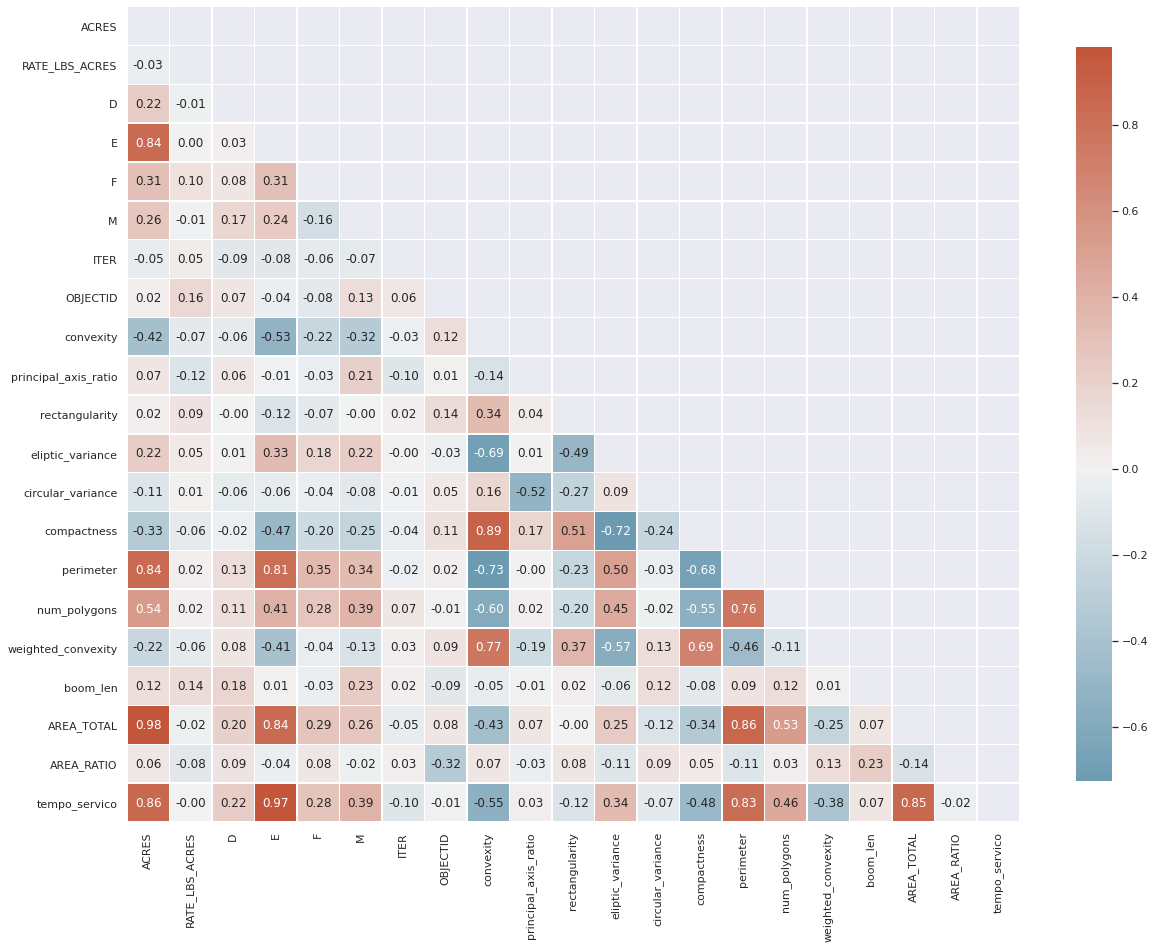

In [ ]:
train_data=train_data.drop(['RATE_GAL_ACRES'], axis=1)

corr=train_data.iloc[:, 1:].corr()
#display(corr)

dict_corr=get_correlations(corr, corr_threshold=0.5) #dict with the highest abs correlations between all dataset features
#display(dict_corr)

features_to_consider={} #dict with features correlated to the target, such as abs(corr)>0.5
for index, value in dict_corr.items():
      if index[0]=='tempo_servico':
        try:
          features_to_consider[index[1]].append(value)
        except:
          features_to_consider[index[1]]=[value]
      elif index[1]=='tempo_servico':
        try:
          features_to_consider[index[0]].append(value)
        except:
          features_to_consider[index[0]]=[value]

print(features_to_consider) #features correlated to the target with corr_threshold>0.5

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=False, linewidths=.5, cbar_kws={"shrink": .9}, annot=True, fmt='.2f')

# **Feature eng**

> * Criação da variável *eficiencia*, a qual visa descrever a razão entre os atributos ACRES, boom_len e a velocidade média de efetivo (24 km/h). Quanto maior o valor da variável criada, mais eficiente a ordem de serviço considerando apenas a área trabalhada dos talhões e a largura do implemento do pulverizador.

* A variável criada apresenta correlação forte de 0.85 em relação ao target. Isso se deve a utilização da variável *ACRES*, que apresenta alta correlação de 0.86.

> * Criação da variável *area_por_total*, a qual visa relacionar a área trabalhada e área total do talhão. Quanto maior o valor da variável gerada, mais eficiente a ordem de serviço considerando o tamanho da área trabalhada e a área total dos talhões.

* A variável criada apresenta correlação forte de 0.85 em relação ao target. Isso se deve a utilização da variável *ACRES*, que apresenta alta correlação de 0.86.



count    113.000000
mean      17.570784
std       14.145495
min        0.312000
25%        6.678000
50%       15.147000
75%       23.945143
max       76.432941
Name: eficiencia, dtype: float64

0.8472529788349505

count      113.000000
mean      5651.375387
std      10378.738485
min          1.131934
25%        423.547543
50%       2660.923298
75%       6286.294532
max      76640.371346
Name: area_por_total, dtype: float64

0.8123571100467335

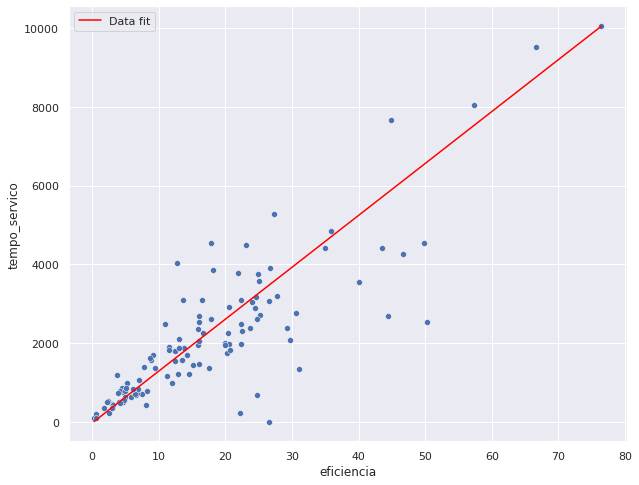

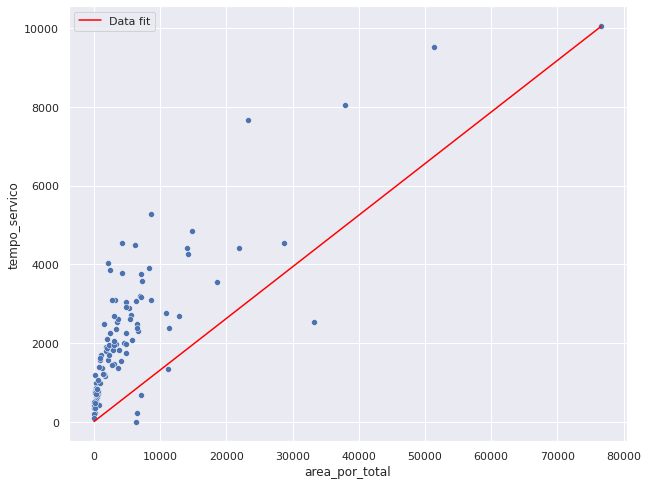

In [ ]:
##creation of feature eficiencia 
train_data['eficiencia']=train_data['ACRES']/train_data['boom_len']*24.0
display(train_data['eficiencia'].describe())

corr=train_data.iloc[:, 1:].corr()
display(corr['eficiencia']['tempo_servico'])

sns.set()
plt.figure(figsize=(10, 8))
sns.scatterplot(x='eficiencia', y='tempo_servico', data=train_data)
sns.lineplot(x=[min(train_data['eficiencia']), max(train_data['eficiencia'])], y = [min(train_data['tempo_servico']), max(train_data['tempo_servico'])], label='Data fit', color='red')

##creation of feature area_por_total 
train_data['area_por_total']=train_data['ACRES']*train_data['AREA_TOTAL']
display(train_data['area_por_total'].describe())

corr=train_data.iloc[:, 1:].corr()
display(corr['area_por_total']['tempo_servico'])

sns.set()
plt.figure(figsize=(10, 8))
sns.scatterplot(x='area_por_total', y='tempo_servico', data=train_data)
sns.lineplot(x=[min(train_data['area_por_total']), max(train_data['area_por_total'])], y = [min(train_data['tempo_servico']), max(train_data['tempo_servico'])], label='Data fit', color='red')

Total de valores da feature key_id2:
3003    35
3001    20
3203    17
3606    15
3604    14
3605    11
3400     1
dtype: int64

Classes de valores únicos da feature key_id2:
['3604' '3203' '3003' '3606' '3400' '3001' '3605']

count      113
unique       7
top       3003
freq        35
dtype: object 



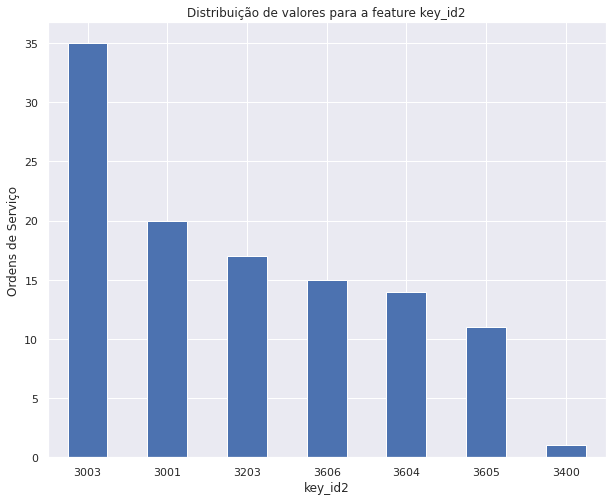

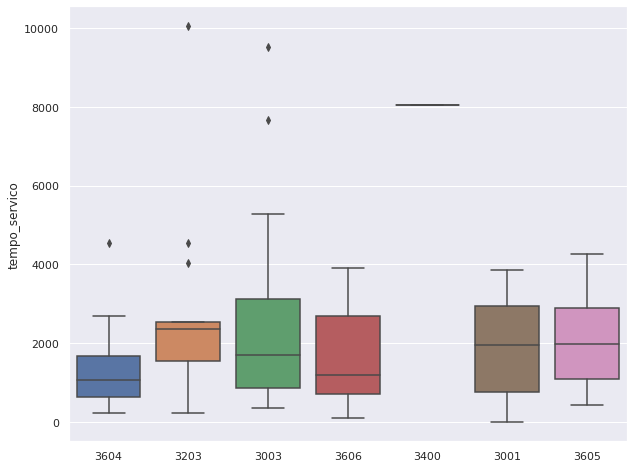

Total de valores da feature key_id5:
7300    67
6203    26
6200    20
dtype: int64

Classes de valores únicos da feature key_id5:
['7300' '6203' '6200']

count      113
unique       3
top       7300
freq        67
dtype: object 



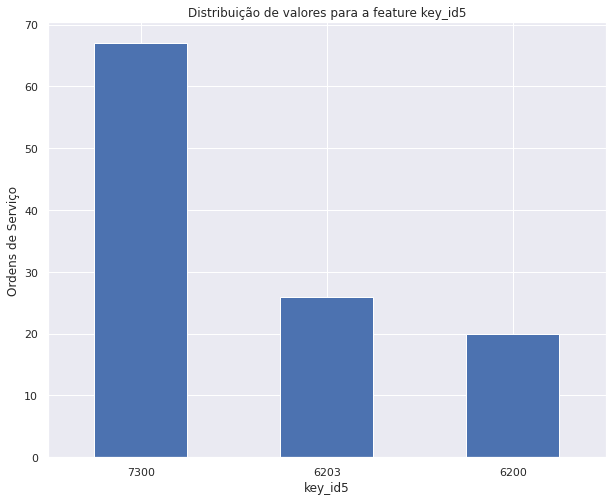

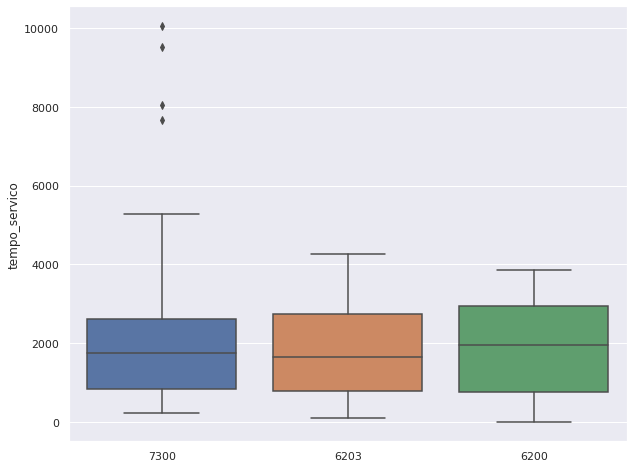

<Figure size 720x576 with 0 Axes>

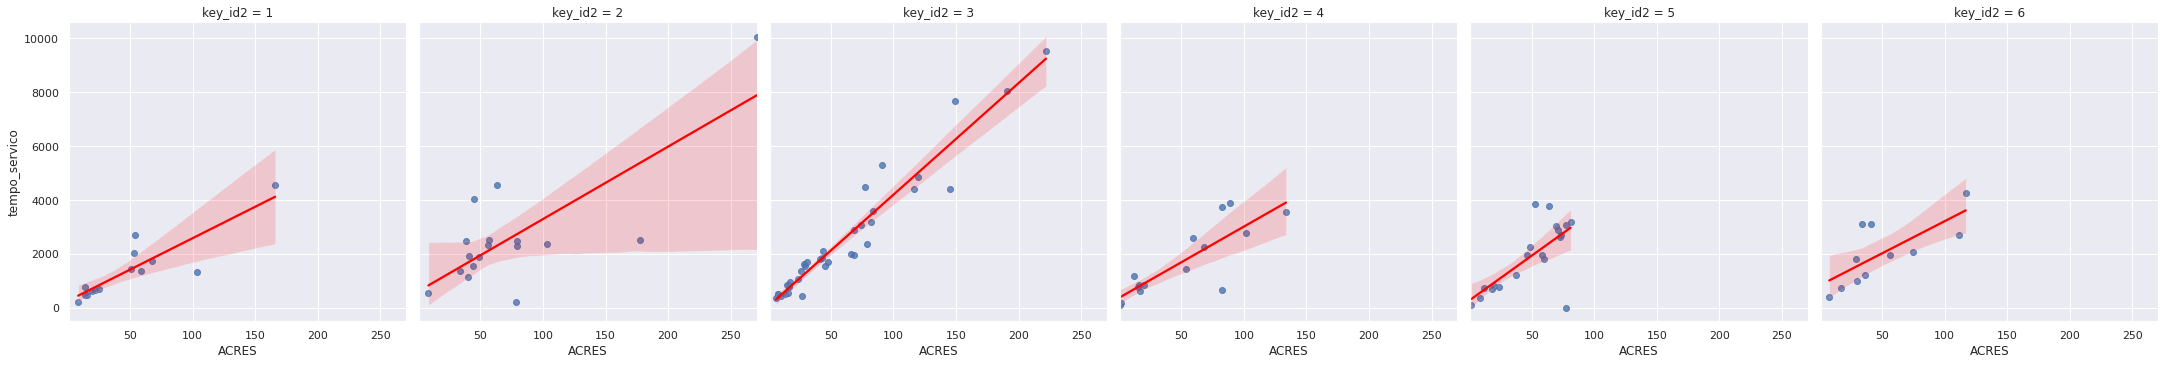

<Figure size 720x576 with 0 Axes>

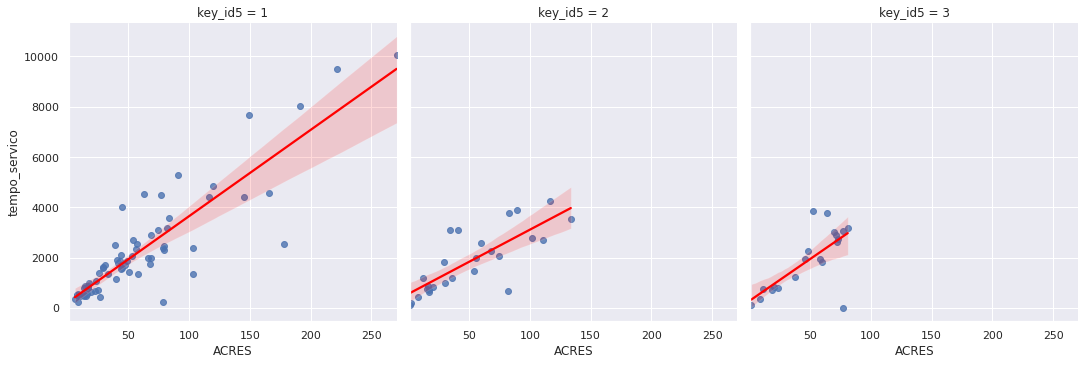

In [ ]:
##investigation of feature KEY 
key_names=train_data['KEY'].str.split()
key_date=pd.Series([key_names[i][0].split('|')[0] for i in range(len(key_names))]) #date
key_id1=pd.Series([key_names[i][0].split('|')[1] for i in range(len(key_names))]) #high cardinality
key_id2=pd.Series([key_names[i][0].split('|')[2] for i in range(len(key_names))]) #7 classes
key_id3=pd.Series([key_names[i][2] for i in range(len(key_names))]) #7 classes (this class represent the same data of key_id2 with different labels)
key_id4=pd.Series([key_names[i][4] for i in range(len(key_names))]) #single value without variation
key_id5=pd.Series([key_names[i][5] for i in range(len(key_names))]) #3 classes

#print(len(key_names))

##key_id2
var='key_id2'
print('Total de valores da feature %s:\n%s\n' % (var, key_id2.value_counts())) #feature com valores desbalanceados
print('Classes de valores únicos da feature %s:\n%s\n'  % (var, key_id2.unique())) #descrição dos valores únicos da feature
print(key_id2.describe(), '\n')
plt.figure(figsize=(10, 8))
ax=key_id2.value_counts().plot.bar()
ax.set_title('Distribuição de valores para a feature '+var)
ax.set_ylabel('Ordens de Serviço')
ax.set_xlabel('key_id2')
ax.tick_params(axis='x', labelrotation=0)

sns.set()
plt.figure(figsize=(10, 8))
sns.boxplot(y=train_data['tempo_servico'], x=key_id2)
plt.show()

##key_id5
var='key_id5'
print('Total de valores da feature %s:\n%s\n' % (var, key_id5.value_counts())) #feature com valores desbalanceados
print('Classes de valores únicos da feature %s:\n%s\n'  % (var, key_id5.unique())) #descrição dos valores únicos da feature
print(key_id5.describe(), '\n')
plt.figure(figsize=(10, 8))
ax=key_id5.value_counts().plot.bar()
ax.set_title('Distribuição de valores para a feature '+var)
ax.set_ylabel('Ordens de Serviço')
ax.set_xlabel('key_id5')
ax.tick_params(axis='x', labelrotation=0)

sns.set()
plt.figure(figsize=(10, 8))
sns.boxplot(y=train_data['tempo_servico'], x=key_id5)
plt.show()

##creation of features key_id2 and key_id5 
train_data['key_id2']=key_id2
train_data['key_id2']=train_data['key_id2'].astype(int)
train_data['key_id2']=train_data['key_id2'].replace({3604: 1, 3203: 2, 3003: 3, 3606: 4, 3400: 3, 3001: 5, 3605: 6})

train_data['key_id5']=key_id5
train_data['key_id5']=train_data['key_id5'].astype(int) 
train_data['key_id5']=train_data['key_id5'].replace({7300: 1, 6203: 2, 6200: 3})

sns.set()
plt.figure(figsize=(10, 8))
sns.lmplot(x='ACRES', y='tempo_servico', data=train_data, line_kws={'color':'red'}, col='key_id2')

sns.set()
plt.figure(figsize=(10, 8))
sns.lmplot(x='ACRES', y='tempo_servico', data=train_data, line_kws={'color':'red'}, col='key_id5')


# **ML steps**

> Problema a ser resolvido: Considerando os atributos do dataset, o modelo de ML visa estimar o tempo em que um pulverizador finaliza uma certa ordem de serviço de acordo com a variável alvo *tempo_servico*, gerada através da soma dos atributos *Efetivo (E)*, *Deslocamento (D)* e *Manobra (M)*.

* Visto que a variável alvo representa valores contínuos, usaremos modelos de regressão para o treinamento e estimação de valores.

**Etapas de ajuste do modelo de ML ao dataset:**
1. Definição das features utilizadas no modelo de ML.

2. Divisão da base em treino e validação (*data split*).

3. Ajuste dos dados de treino (*fit*).

4. Predição e cálculo da acurácia para o conjunto de validação/teste (*prediction* e *score*).

## **Features employed in ML models**

X = features de treino (variáveis independentes)\
y = *target* (variável dependente)

* **Teste 1) Inicialmente, todas as features do dataset serão utilizadas, exceto as features que compõe a variável alvo *tempo_servico* (*D, E, F, M*), feature de índices e chaves.**

* **Teste 2) Adição das features elaboradas na etapa de feature engineering (*eficiencia, area_por_total, key_id2, key_id5*) às features do dataset já utilizadas no conjunto de features do teste 1.**

* **Teste 3) Nessa composição de features, apenas as variáveis que apresentaram correlação absoluta de moderada à alta (abs(corr)>0.5) em relação ao target, indicadas na etapa de correlação entre features, serão consideradas.**

* **Teste 4) Nesse teste, serão consideradas as features que apresentaram scores de importância mais expressivos (abs(importance) > 1000), considerando o resultado do cálculo de importância das features durante o treinamento do modelo de regressão linear no teste 2.**

* **Teste 5) Conjunto de features já consideradas no teste 4 (features com score de importância mais elevado) combinadas às features do teste 3 (features com correlação de moderada à alta em relação ao target) não consideradas no teste 4.**

In [ ]:
display(train_data.columns)

##features used to train the models
initial_features = ['ACRES', 'RATE_LBS_ACRES', 'ITER', 'OBJECTID', 'convexity', 'principal_axis_ratio', 'rectangularity', 'eliptic_variance', 'circular_variance', 'compactness', 'perimeter', 
       'num_polygons', 'weighted_convexity', 'boom_len', 'AREA_TOTAL', 'AREA_RATIO']

features = ['ACRES', 'RATE_LBS_ACRES', 'ITER', 'OBJECTID', 'convexity', 'principal_axis_ratio', 'rectangularity', 'eliptic_variance', 'circular_variance', 'compactness', 'perimeter', 
       'num_polygons', 'weighted_convexity', 'boom_len', 'AREA_TOTAL', 'AREA_RATIO', 'eficiencia', 'area_por_total', 'key_id2', 'key_id5']

X = train_data[features] #independent variables
y = train_data['tempo_servico'] #target

#display(X)
#display(y)

Index(['Unnamed: 0', 'KEY', 'ACRES', 'RATE_LBS_ACRES', 'D', 'E', 'F', 'M',
       'ITER', 'OBJECTID', 'convexity', 'principal_axis_ratio',
       'rectangularity', 'eliptic_variance', 'circular_variance',
       'compactness', 'perimeter', 'num_polygons', 'weighted_convexity',
       'boom_len', 'AREA_TOTAL', 'AREA_RATIO', 'tempo_servico', 'eficiencia',
       'area_por_total', 'key_id2', 'key_id5'],
      dtype='object')

**Divisão do dataset em treino e validação/teste:**

> test_size = 0.25 -> Tamanho para a base de teste (validação). A proporção entre treino e teste varia de acordo com o volume de dados disponível.

> O modelo será testado seguindo a proporção de 25/75, o que significa que a base de teste será composta por 25% dos dados, e a base de treino será composta pelos 75% restantes.

In [ ]:
##dataset split between train and validation
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state=376) #test_size=0.3, 0.5

#display(train_X)
#display(val_X)
#display(train_y)
#display(val_y)

**Normalização de features:**

In [ ]:
##scaling of some features out of scale
norm_features = ['ACRES', 'RATE_LBS_ACRES', 'ITER', 'OBJECTID', 'num_polygons', 'boom_len', 'AREA_TOTAL', 'eficiencia', 'area_por_total']

train_X, val_X=std_features(train_X, val_X, norm_features)
#train_X, val_X=norm_features(train_X, val_X, norm_features)

#display(train_X.describe())
#display(val_X.describe())

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


## **ML models**

> Datasets:

* Treino: train_X, train_y

* Validação/teste: val_X, val_y

### **Baseline model: Dummy Regressor**

Dummy Regressor utilizando a média dos valores como variável alvo.

Será empregada a estratégia da média dos valores da variável alvo: dada a média dos valores do target (*tempo_servico*), o modelo Dummy vai inferir que todos os registros da base de dados assumem o valor da média na variável target.

In [ ]:
dummy_model = DummyRegressor('mean') #baseline model
dummy_model.fit(train_X, train_y) #treino
#print(dummy_model.score(train_X, train_y))

dummy_prediction=dummy_model.predict(val_X) #prediction

calc_regression_metrics('Dummy Regressor', val_y, dummy_prediction) #acc metrics of dummy regressor

'Dummy Regressor prediction | Regression metric:'

r2: -0.006250361363032253
MAE: 1378.7713464696224
MSE: 3943997.9707023613


(-0.006250361363032253, 1378.7713464696224, 3943997.9707023613)

### **1) Linear Regression algorithm**

> **Teste 1) Todas as features do dataset são utilizadas, exceto as features que compõe a variável alvo *tempo_servico* (*D, E, F, M*), feature de índices e chaves.**

In [ ]:
lr_model = LinearRegression() #linear regression model
lr_model.fit(train_X[initial_features], train_y) #train with initial_features
#print(lr_model.score(train_X, train_y))

lr_prediction=lr_model.predict(val_X[initial_features]) #prediction

calc_regression_metrics('Linear Regression', val_y, lr_prediction) #acc metrics of linear regression

'Linear Regression prediction | Regression metric:'

r2: 0.6237071933644551
MAE: 799.0422869575773
MSE: 1474879.5356954471


(0.6237071933644551, 799.0422869575773, 1474879.5356954471)

**Seleção simples de atributos para novos testes com o modelo de Regressão Linear:**

> **Teste 2) Adição das features elaboradas na etapa de feature engineering (*eficiencia, area_por_total, key_id2, key_id5*) às features do dataset já utilizadas no teste 1.**

> **É possível observar que o modelo de regressão treinado com novas features apresentou métricas de acurácia superiores ao modelo inicial (teste 1).**

In [ ]:
lr_model = LinearRegression() #linear regression model
lr_model.fit(train_X, train_y) #train with all features
#print(lr_model.score(train_X, train_y))

lr_prediction=lr_model.predict(val_X) #prediction

calc_regression_metrics('Linear Regression', val_y, lr_prediction) #acc metrics of linear regression

'Linear Regression prediction | Regression metric:'

r2: 0.6455646925328004
MAE: 800.9742149636609
MSE: 1389209.0746704093


(0.6455646925328004, 800.9742149636609, 1389209.0746704093)

**Feature importance computation of the Linear Regression model regarding test 2:**


Feature importance: 0 (ACRES), Score: 2136.19081
Feature importance: 1 (RATE_LBS_ACRES), Score: -33.36933
Feature importance: 2 (ITER), Score: 61.76319
Feature importance: 3 (OBJECTID), Score: 71.50367
Feature importance: 4 (convexity), Score: -6378.46925
Feature importance: 5 (principal_axis_ratio), Score: -823.06599
Feature importance: 6 (rectangularity), Score: -1460.88831
Feature importance: 7 (eliptic_variance), Score: 159.82162
Feature importance: 8 (circular_variance), Score: 210.54261
Feature importance: 9 (compactness), Score: 3051.19690
Feature importance: 10 (perimeter), Score: 51824.38518
Feature importance: 11 (num_polygons), Score: -943.55077
Feature importance: 12 (weighted_convexity), Score: 3540.34517
Feature importance: 13 (boom_len), Score: 164.60356
Feature importance: 14 (AREA_TOTAL), Score: -2159.16957
Feature importance: 15 (AREA_RATIO), Score: -5341.13098
Feature importance: 16 (eficiencia), Score: 515.05772
Feature importance: 17 (area_por_total), Score: 321.5

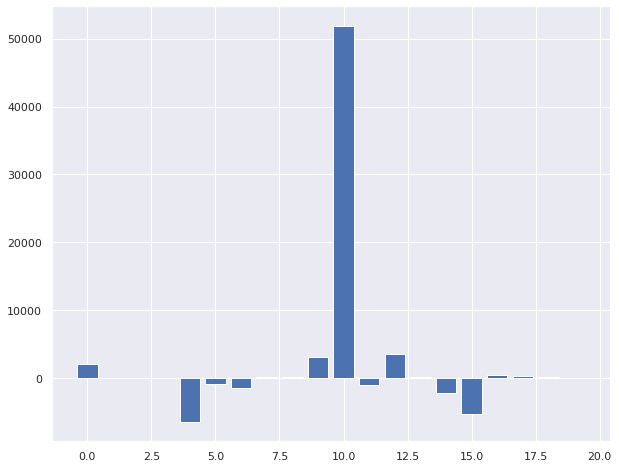

In [ ]:
##feature importance
importance = lr_model.coef_
print("")
for i,v in enumerate(importance):
	print('Feature importance: %0d (%s), Score: %.5f' % (i, features[i], v))
plt.figure(figsize=(10, 8))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

> **Teste 3) Nessa composição de features, apenas as variáveis que apresentaram correlação absoluta de moderada à alta (abs(corr)>0.5) em relação ao target são consideradas.**

> **É possível observar que o modelo de regressão treinado apenas com as features de correlação moderada à alta em relação à variável resposta apresentou métricas de acurácia superiores aos modelos anteriores (testes 1 e 2).**

In [ ]:
correlated_features = ['ACRES', 'convexity', 'perimeter', 'AREA_TOTAL', 'eficiencia', 'area_por_total', 'key_id2', 'key_id5']
#correlated_features = ['ACRES', 'convexity', 'perimeter', 'AREA_TOTAL', 'eficiencia', 'area_por_total']

lr_model = LinearRegression() #linear regression model
lr_model.fit(train_X[correlated_features], train_y) #train only with well correalted features to the target
#print(lr_model.score(train_X, train_y))

lr_prediction=lr_model.predict(val_X[correlated_features]) #prediction

calc_regression_metrics('Linear Regression', val_y, lr_prediction) #acc metrics of linear regression

'Linear Regression prediction | Regression metric:'

r2: 0.7725302307116151
MAE: 642.599735143811
MSE: 891567.6882384312


(0.7725302307116151, 642.599735143811, 891567.6882384312)

> **Teste 4) Nesse teste, são consideradas as features que apresentaram scores de importância mais expressivos (abs(importance) > 1000), considerando o resultado do cálculo de importância das features durante o treinamento do modelo de regressão linear no teste 2.**

> **Observa-se que essa composição de features não conseguiu superar o teste 3 de features correlacionadas com o target.**

In [ ]:
pos_importance_features = ['ACRES', 'compactness', 'perimeter', 'weighted_convexity']
neg_importance_features = ['convexity', 'rectangularity', 'AREA_TOTAL','AREA_RATIO']
important_features = pos_importance_features + neg_importance_features

lr_model = LinearRegression() #linear regression model
lr_model.fit(train_X[important_features], train_y) #train important features according to the linear regression coeffs
#print(lr_model.score(train_X, train_y))

lr_prediction=lr_model.predict(val_X[important_features]) #prediction

calc_regression_metrics('Linear Regression', val_y, lr_prediction) #acc metrics of linear regression

'Linear Regression prediction | Regression metric:'

r2: 0.760098986058896
MAE: 660.500723691421
MSE: 940291.9476933206


(0.760098986058896, 660.500723691421, 940291.9476933206)

> **Teste 5) Conjunto de features consideradas no teste 4 (features importantes) combinadas às features do teste 3 (features correlacionadas com o target) não consideradas no teste 4.**

> **Observa-se que essa composição de features não conseguiu superar os testes 3 e 4.**

In [ ]:
important_features.append('eficiencia')
important_features.append('area_por_total')
important_features.append('key_id2')
important_features.append('key_id5')
print(important_features)

lr_model = LinearRegression() #linear regression model
lr_model.fit(train_X[important_features], train_y) #train with important and well correalted features to the target
#print(lr_model.score(train_X, train_y))

lr_prediction=lr_model.predict(val_X[important_features]) #prediction

calc_regression_metrics('Linear Regression', val_y, lr_prediction) #acc metrics of linear regression

['ACRES', 'compactness', 'perimeter', 'weighted_convexity', 'convexity', 'rectangularity', 'AREA_TOTAL', 'AREA_RATIO', 'eficiencia', 'area_por_total', 'key_id2', 'key_id5']


'Linear Regression prediction | Regression metric:'

r2: 0.7522972006785889
MAE: 672.4440271606172
MSE: 970871.043005253


(0.7522972006785889, 672.4440271606172, 970871.043005253)

### **Cross Validation: *Kfold* with Linear Regression**



'Linear Regression prediction | Regression metric:'

r2: 0.774520124050759
MAE: 531.8233352695697
MSE: 640604.1331480683


'Linear Regression prediction | Regression metric:'

r2: 0.4242998962324003
MAE: 602.3028505710615
MSE: 914492.4538304805


'Linear Regression prediction | Regression metric:'

r2: 0.844977544365378
MAE: 615.5254632069908
MSE: 790951.8199741339


'Linear Regression prediction | Regression metric:'

r2: 0.43269363510923997
MAE: 674.5791150825759
MSE: 1866785.4004433898


'Linear Regression prediction | Regression metric:'

r2: 0.840309170964197
MAE: 479.80821177189176
MSE: 491908.46328832617


'Linear Regression prediction | Regression metric:'

r2: 0.7111109116316993
MAE: 472.70459870141264
MSE: 532341.4131343898


'Linear Regression prediction | Regression metric:'

r2: 0.7559926181006533
MAE: 715.1721387705627
MSE: 1109932.5783928067


'Linear Regression prediction | Regression metric:'

r2: 0.43504984387049583
MAE: 709.1093640501879
MSE: 1597456.9548719055


'Linear Regression prediction | Regression metric:'

r2: 0.45786493151170804
MAE: 808.8924623007639
MSE: 1182770.6420990662


'Linear Regression prediction | Regression metric:'

r2: 0.8243963613737684
MAE: 481.3271657753067
MSE: 484186.398068309


'Linear Regression prediction | Regression metric:'

r2: 0.6527366536921018
MAE: 578.6661551583272
MSE: 1200153.252770006


'Linear Regression prediction | Regression metric:'

r2: 0.8645289400698988
MAE: 465.16570906336347
MSE: 612674.5776344491


'Linear Regression prediction | Regression metric:'

r2: 0.8280613288900736
MAE: 565.7537990843325
MSE: 816828.8154540688


'Linear Regression prediction | Regression metric:'

r2: 0.4815235329250197
MAE: 860.659779502021
MSE: 1709909.6206619292


'Linear Regression prediction | Regression metric:'

r2: 0.8283528108227691
MAE: 471.2302493708412
MSE: 507499.2315605959


'Linear Regression prediction | Regression metric:'

r2: 0.6938684545582879
MAE: 503.7479694993175
MSE: 495038.7918481217


'Linear Regression prediction | Regression metric:'

r2: 0.6957186879389452
MAE: 721.2189378030816
MSE: 1196913.7025527686


'Linear Regression prediction | Regression metric:'

r2: 0.6713281886984014
MAE: 551.0113029117282
MSE: 721510.6663782094


'Linear Regression prediction | Regression metric:'

r2: 0.5616893843654336
MAE: 625.2762787815062
MSE: 1397601.8955668535


'Linear Regression prediction | Regression metric:'

r2: 0.8646307948651427
MAE: 509.87801425204276
MSE: 480052.73066820076


'Linear Regression prediction | Regression metric:'

r2: 0.5492938250127435
MAE: 536.9348716060866
MSE: 607682.0981157639


'Linear Regression prediction | Regression metric:'

r2: 0.5402424779276191
MAE: 534.4193019751921
MSE: 1266025.9911975781


'Linear Regression prediction | Regression metric:'

r2: 0.8832626095005374
MAE: 395.93382678780796
MSE: 389794.9550413984


'Linear Regression prediction | Regression metric:'

r2: 0.7532578867615959
MAE: 805.4762237782054
MSE: 1297547.2460623102


'Linear Regression prediction | Regression metric:'

r2: 0.21036507498832746
MAE: 483.76488993499055
MSE: 1098153.8193976318


'Linear Regression prediction | Regression metric:'

r2: 0.6197989572058253
MAE: 678.0005292741446
MSE: 982780.2492798015


'Linear Regression prediction | Regression metric:'

r2: 0.6044539107961155
MAE: 491.18653127417025
MSE: 497987.52698856045


'Linear Regression prediction | Regression metric:'

r2: 0.5801638342732167
MAE: 1073.3309363034907
MSE: 3019910.230305425


'Linear Regression prediction | Regression metric:'

r2: 0.8235922191886896
MAE: 449.42874990949645
MSE: 447394.84139285056


'Linear Regression prediction | Regression metric:'

r2: 0.47580328085857115
MAE: 599.764518989245
MSE: 817762.1932188795


'Linear Regression prediction | Regression metric:'

r2: 0.7990433506092943
MAE: 454.39125294096783
MSE: 509494.4718782725


'Linear Regression prediction | Regression metric:'

r2: 0.6386769138724705
MAE: 940.6790425970693
MSE: 2099757.195144632


'Linear Regression prediction | Regression metric:'

r2: 0.8426907922715168
MAE: 466.14282500538184
MSE: 832470.6291210093


'Linear Regression prediction | Regression metric:'

r2: -0.04979036942988713
MAE: 864.0936754492898
MSE: 1669253.7811626515


'Linear Regression prediction | Regression metric:'

r2: 0.7724410399635916
MAE: 574.2211797181469
MSE: 740670.1138883291


'Linear Regression prediction | Regression metric:'

r2: 0.6156179899585783
MAE: 663.0312765989519
MSE: 985293.9213996992


'Linear Regression prediction | Regression metric:'

r2: 0.8068171280240091
MAE: 625.1782390239177
MSE: 852206.6503816292


'Linear Regression prediction | Regression metric:'

r2: -0.08776854738104256
MAE: 644.4867363230495
MSE: 1565737.6475586656


'Linear Regression prediction | Regression metric:'

r2: 0.8782072346161867
MAE: 514.9612602669138
MSE: 613566.5923886106


'Linear Regression prediction | Regression metric:'

r2: 0.5273733337820634
MAE: 626.4989441055571
MSE: 804135.769773206
0.6356799189209099 -0.08776854738104256 0.8832626095005374


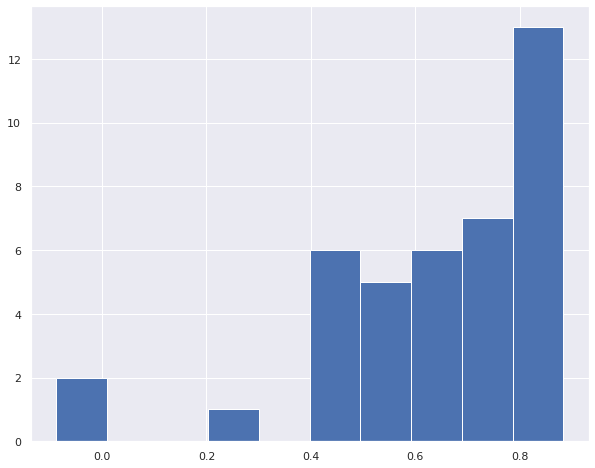

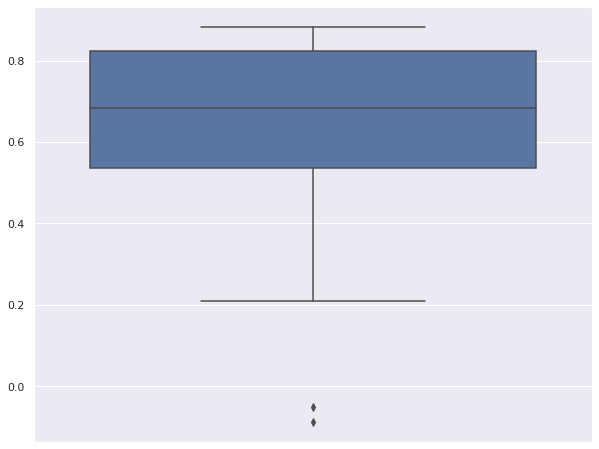

In [ ]:
X_kfold=pd.concat([train_X, val_X], ignore_index=True)
y_kfold=pd.concat([train_y, val_y], ignore_index=True)

kf=RepeatedKFold(n_splits=4, n_repeats=10, random_state=376)
list_acc=[]
for l_train, l_val in kf.split(X_kfold):
  #print(l_train.shape[0], l_val.shape[0])
  train_Xkfold, val_Xkfold = X_kfold.iloc[l_train], X_kfold.iloc[l_val]
  train_ykfold, val_ykfold = y_kfold.iloc[l_train], y_kfold.iloc[l_val]

  lr_model = LinearRegression() #linear regression model
  lr_model.fit(train_Xkfold[correlated_features], train_ykfold) #train with important and well correalted features to the target
  #print(lr_model.score(train_X, train_y))

  lr_prediction=lr_model.predict(val_Xkfold[correlated_features]) #prediction

  acc, _, _ = calc_regression_metrics('Linear Regression', val_ykfold, lr_prediction) #acc metrics of linear regression

  list_acc.append(acc)

print(np.mean(list_acc), np.min(list_acc), np.max(list_acc))

##plotting results
plt.figure(figsize=(10, 8))
plt.hist(list_acc)
plt.show()

sns.set()
plt.figure(figsize=(10, 8))
sns.boxplot(y=list_acc)
plt.show()

,tempo_real,tempo_predito
7,216.0,2401.437845
10,2496.0,1239.577253
12,675.0,2542.359908
18,1913.0,1749.857553
20,2906.0,2854.021565


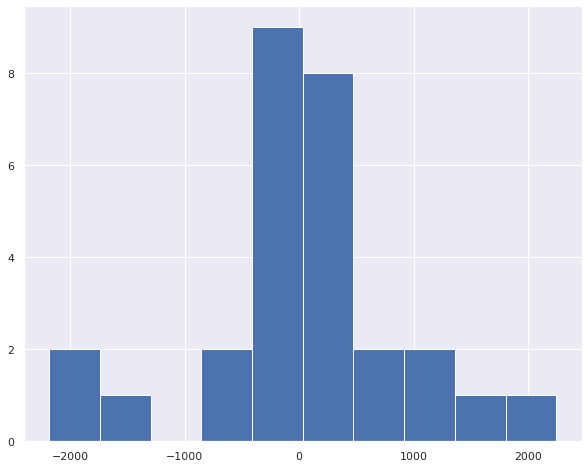

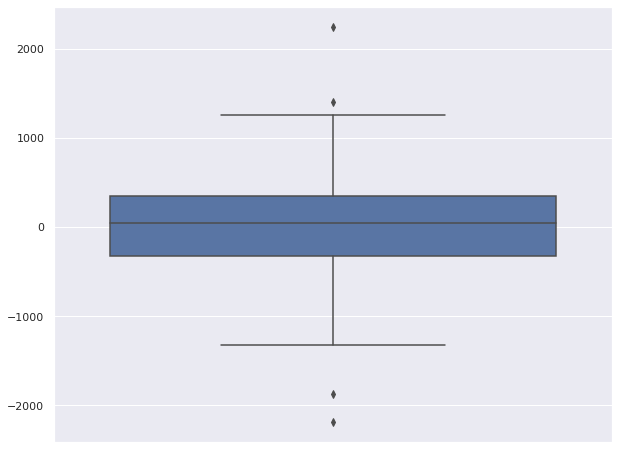

In [ ]:
val_comparison={}
val_comparison['tempo_real'] = y_kfold.iloc[l_val].copy()
val_comparison['tempo_predito'] = lr_prediction
val_comparison=pd.DataFrame(val_comparison)
display(val_comparison.head())

X_errors=val_comparison['tempo_real']-val_comparison['tempo_predito'] #show only the errors between prediciton and expected output
#display(X_errors)
##plotting results
plt.figure(figsize=(10, 8))
plt.hist(X_errors)
plt.show()

sns.set()
plt.figure(figsize=(10, 8))
sns.boxplot(y=X_errors)
plt.show()

### **2) Random Forest algorithm**

Teste com o algoritmo Random Forest utilizando o conjunto de features definido inicialmente. 

Adicionalmente, aplicação do modelo utilizando também o conjunto de melhor acurácia nos testes de regressão linear, sendo resultante do teste 3. 

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=376) #random forest model
rf_model.fit(train_X, train_y) #train
#print(rf_model.score(train_X, train_y))

rf_prediction=rf_model.predict(val_X) #prediction

calc_regression_metrics('Random Forest', val_y, rf_prediction) #acc metrics of random forest

##test with correlated features
rf_model = RandomForestRegressor(n_estimators=100, random_state=376) #random forest model
rf_model.fit(train_X[correlated_features], train_y) #train
#print(rf_model.score(train_X, train_y))

rf_prediction=rf_model.predict(val_X[correlated_features]) #prediction

print('')
calc_regression_metrics('Random Forest', val_y, rf_prediction) #acc metrics of random forest

'Random Forest prediction | Regression metric:'

r2: 0.6981471226419896
MAE: 752.0296551724136
MSE: 1183112.256613793



'Random Forest prediction | Regression metric:'

r2: 0.7321689517203698
MAE: 697.6120689655173
MSE: 1049763.7083827585


(0.7321689517203698, 697.6120689655173, 1049763.7083827585)

### **3) Gradient Boosting algorithm for regression**

Teste com o algoritmo Gradient Boosting utilizando o conjunto de features definido inicialmente.

Adicionalmente, aplicação do modelo utilizando também o conjunto de melhor acurácia nos testes de regressão linear, sendo resultante do teste 3. 

In [ ]:
gb_model = GradientBoostingRegressor(random_state=376) #gradient boosting model
gb_model.fit(train_X, train_y) #train
#print(xgb_model.score(train_X, train_y))

gb_prediction=gb_model.predict(val_X) #prediction

calc_regression_metrics('Gradient Boosting', val_y, gb_prediction) #acc metrics of gradient boosting

##test with correlated features
gb_model = GradientBoostingRegressor(random_state=376) #gradient boosting model
gb_model.fit(train_X[correlated_features], train_y) #train
#print(xgb_model.score(train_X, train_y))

gb_prediction=gb_model.predict(val_X[correlated_features]) #prediction

print('')
calc_regression_metrics('Gradient Boosting', val_y, gb_prediction) #acc metrics of gradient boosting

'Gradient Boosting prediction | Regression metric:'

r2: 0.6972850356028253
MAE: 754.6201168766404
MSE: 1186491.206489078



'Gradient Boosting prediction | Regression metric:'

r2: 0.5368996796120444
MAE: 875.7928973706136
MSE: 1815121.5581852226


(0.5368996796120444, 875.7928973706136, 1815121.5581852226)

# **Final remarks**

> Para finalizar o projeto, nota-se que através da utilização de modelos de ML é possível estimar o tempo que um pulverizador finalizará uma ordem de serviço. Porém, existem variáveis que se mostram mais relevantes do que outras, como as features *ACRES, perimeter e AREA_TOTAL*, e que devem ser melhor consideradas visando o aumento da acurácia dos modelos de ML.

> Além disso, é necessário que ajustes mais finos sejam realizados para que as acurácias dos modelos e a qualidade das estimativas possam ser melhoradas. Por exemplo, é possível realizar um trabalho mais aprofundado de feature engineering e seleção de atributos visando selecionar features que descrevam de forma mais acertiva a variável resposta, cross-validation e otimização dos parâmetros dos modelos de forma complementar.